In [1]:
# 2. prepare datasets for regression

import numpy as np
import math
import os

def f1(x):
    return 5 * x**3 - 2 * x**2 + 3 * x - 17


def f2(x):
    return np.sin(x) + np.cos(x)


def f3(x):
    return 2 * np.log(x + 1)


def f4(x, y):
    return x + 2 * y


def f5(x, y):
    return np.sin(x / 2) + 2 * np.cos(x)


def f6(x, y):
    return x**2 + 3 * x * y - 7 * y + 1

domains = {
    "f1": [(-10, 10), (0, 100), (-1, 1), (-1000, 1000)],
    "f2": [(-3.14, 3.14), (0, 7), (0, 100), (-100, 100)],
    "f3": [(0, 4), (0, 9), (0, 99), (0, 999)],
    "f4": [(0, 1), (-10, 10), (0, 100), (-1000, 1000)],
    "f5": [(-3.14, 3.14), (0, 7), (0, 100), (-100, 100)],
    "f6": [(-10, 10), (0, 100), (-1, 1), (-1000, 1000)],
}


def write_data(filename, num_vars, num_constants, min_rand, max_rand, num_data_points, results, *vars):
    vars = list(zip(*vars)) # vars = vars.T

    with open(filename, "w") as file:
        file.write(f"{num_vars} {num_constants} {min_rand} {max_rand} {num_data_points}\n")
        for i in range(num_data_points):
            file.write(" ".join([str(v) for v in vars[i]]))
            file.write(f" {results[i]}\n")

def gen_data(f, domain, num_data_points=100, num_constants=100):
    n_args = f.__code__.co_argcount
    vars = [np.random.uniform(*domain, num_data_points) for _ in range(n_args)]
    results = [f(*v) for v in zip(*vars)]
    filename = f".dat/{f.__name__}_{domain[0]}_{domain[1]}.dat"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    write_data(filename, n_args, num_constants, domain[0], domain[1], num_data_points, results, *vars)


# Generate data points and write to separate .dat files
for func_name, func_domains in domains.items():
    func = globals()[func_name]
    n_vars = func.__code__.co_argcount
    for domain in func_domains:
        gen_data(func, domain)


(100, 1) (100,)
(100, 1) (100,)
(100, 1) (100,)
(100, 2) (100,)
(100, 2) (100,)
(100, 2) (100,)


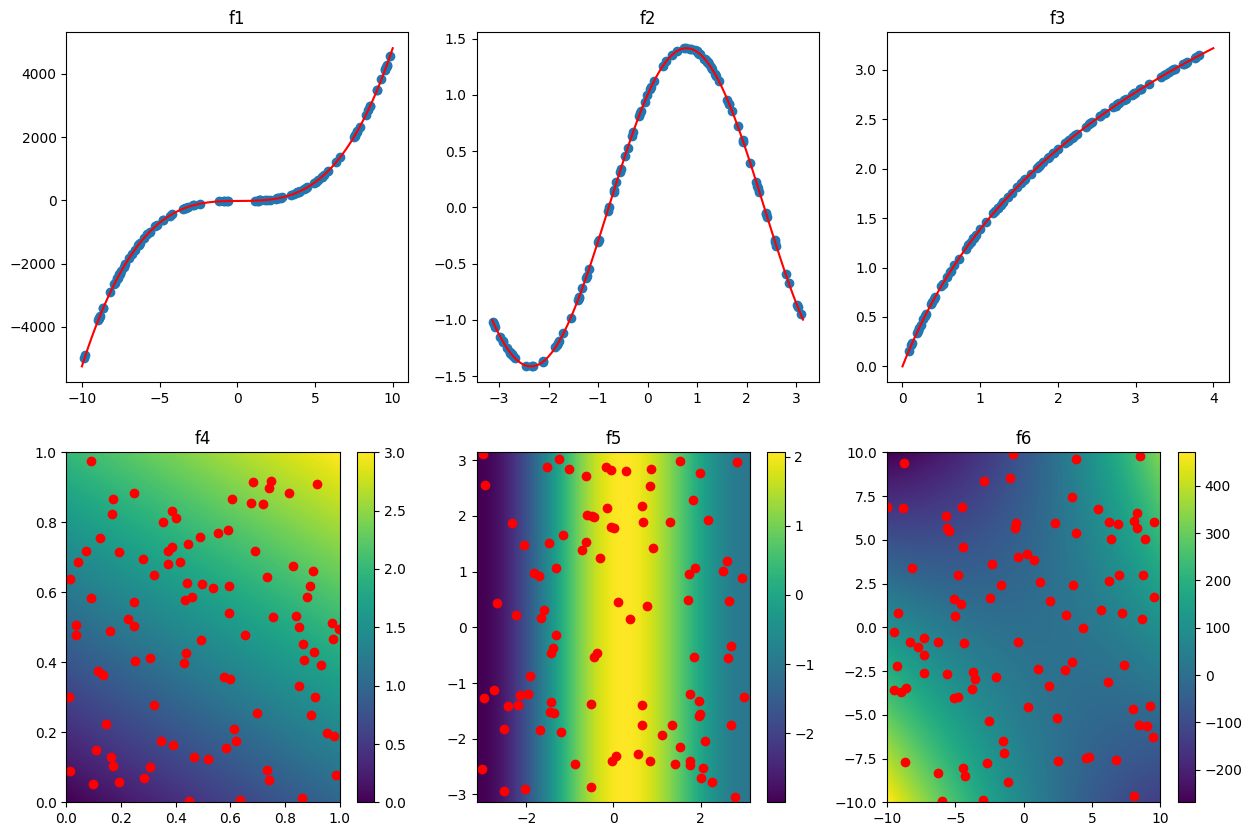

In [2]:
# Plot one dataset of each function
import matplotlib.pyplot as plt
import numpy as np

def load_data_points(filename) -> tuple[np.ndarray, np.ndarray]:
    with open(filename) as file:
        data = np.loadtxt(file, skiprows=1)
        return data[:, :-1], data[:, -1]

fig, axs = plt.subplots(2, round(np.ceil(len(domains) / 2)), figsize=(15, 10))
axs = axs.flatten()

ax_i = 0
for func_name, func_domains in domains.items():
    func = globals()[func_name]
    domain = func_domains[0]
    filename = f".dat/{func_name}_{domain[0]}_{domain[1]}.dat"
    X, y = load_data_points(filename)
    print(X.shape, y.shape)
    if X.shape[1] == 1:
        axs[ax_i].scatter(X, y)
        # plot function
        x = np.linspace(domain[0], domain[1], 100)
        y = [func(x_i) for x_i in x]
        axs[ax_i].plot(x, y, c='red')
    else:
        x = np.linspace(domain[0], domain[1], 100)
        y = np.linspace(domain[0], domain[1], 100)
        X_grid, Y_grid = np.meshgrid(x, y)
        Z_grid = func(X_grid, Y_grid)
        heatmap = axs[ax_i].imshow(Z_grid, extent=(domain[0], domain[1], domain[0], domain[1]), origin='lower', aspect='auto')
        axs[ax_i].scatter(X[:, 0], X[:, 1], c='red')
        fig.colorbar(heatmap, ax=axs[ax_i])
        

    axs[ax_i].set_title(func_name)
    ax_i += 1

plt.show()

Evolving .dat/f1_-10_10.dat...
	domain: -9.833205034623298 - 9.8294814041389, width: 19.662686438762197, eps: 19.662686438762197
	expression: (((6.41 + 2.73) - (((-2.43 + (((-1.27 + X1) + (-6.96 / (-2.62 + (X1 - ((((9.48 / -2.37) + 2.98) - X1) - (((-6.45 * 4.27) - 5.03) - -1.31)))))) * -5.61)) / 2.73) - -9.04)) * ((X1 * (6.55 - ((-1.65 + -6.41) - (((((-4.39 + X1) / X1) + 3.31) / -6.41) / -0.62)))) * (X1 / 6.41)))
	fitness: -2809.8174482460727
Evolving .dat/f2_-3.14_3.14.dat...
	domain: -3.1199081562699136 - 3.0950418001213413, width: 6.214949956391255, eps: 6.214949956391255
	expression: (((-0.12 / 1.58) * ((X1 * (2.30 - (-0.88 * ((((1.65 - ((X1 / 2.78) * ((-0.17 / ((2.53 * (-1.31 - 1.88)) - ((-0.08 + 0.30) * 2.01))) - (1.59 * (-0.31 * (-1.38 + (X1 * ((2.98 + (-0.25 + ((-2.80 * -0.31) + (-0.08 / (-2.94 - (-1.89 * -2.64)))))) + (2.01 / 2.70))))))))) * -0.17) * -2.57) - X1)))) + 2.90)) * (-1.42 * 1.87))
	fitness: -31.7036404214529
Evolving .dat/f3_0_4.dat...
	domain: 0.08311348830463539 

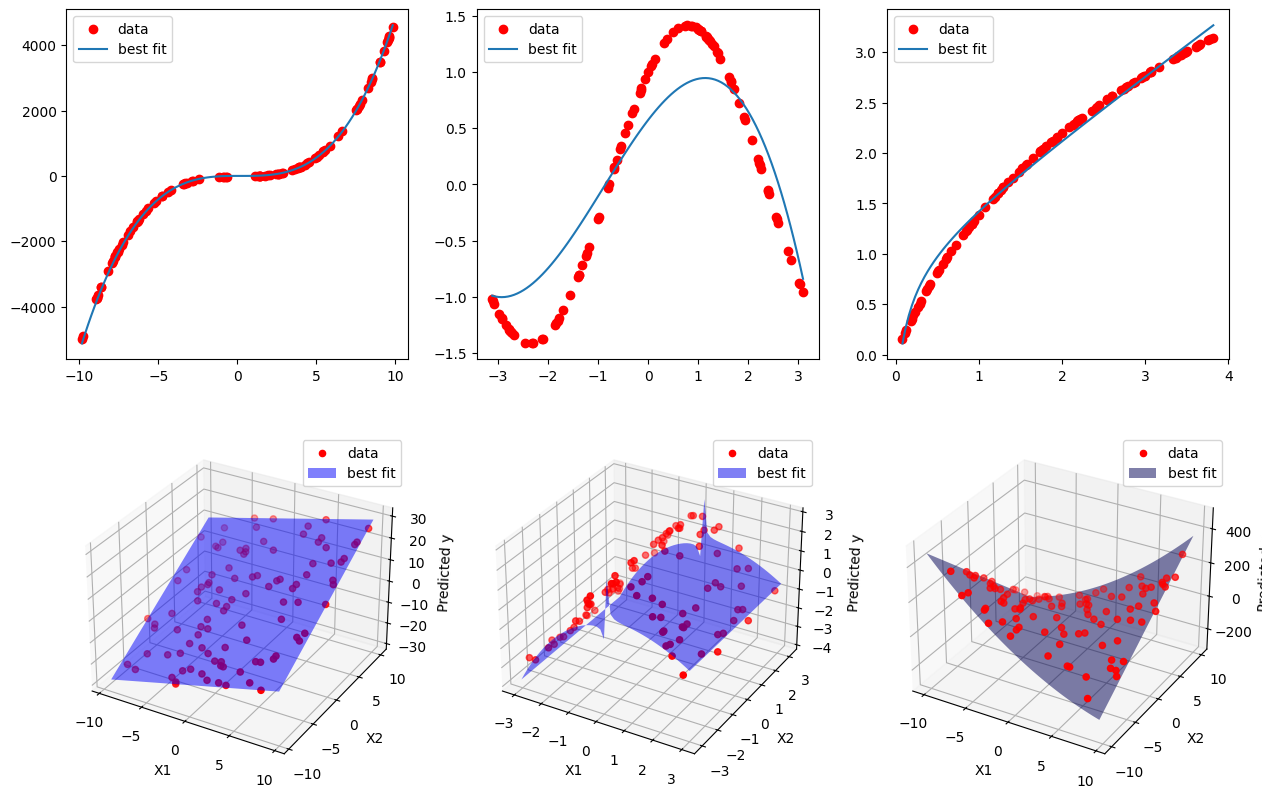

In [3]:
# 1. import refactored Tiny GP
from tiny_gp import TinyGP
from numpy import sin, cos

FILENAMES = [
    ".dat/f1_-10_10.dat",
    ".dat/f2_-3.14_3.14.dat",
    ".dat/f3_0_4.dat",
    ".dat/f4_-10_10.dat",
    ".dat/f5_-3.14_3.14.dat",
    ".dat/f6_-10_10.dat"
]

fig = plt.figure(figsize=(15, 10))
rows = 2
cols = 3

for i, filename in enumerate(FILENAMES):
    print(f"Evolving {filename}...")

    # Read domain values
    X, y = load_data_points(filename)
    width = np.max(X) - np.min(X)
    eps = width * 0.01 * len(X)
    print(f"\tdomain: {np.min(X)} - {np.max(X)}, width: {width}, eps: {eps}")

    # 2. symbolic regression for different functions
    tgp = TinyGP(filename, lib_name="tiny_gp_no_sin_cos")
    for _ in range(10):
        tgp.evolve()
        if tgp.fitness(tgp.best()) > -eps:
            break

    print(f"\texpression: {tgp.str(tgp.best())}")
    print(f"\tfitness: {tgp.fitness(tgp.best())}")
    best_exp = tgp.str(tgp.best(), 5) # higher precision for eval

    # 4. comparative plots
    if X.shape[1] == 1:
        ax = fig.add_subplot(2, 3, i+1)

        ax.scatter(X, y, c='red', label='data')
        x = np.linspace(np.min(X), np.max(X), 100)
        def best_exp_func(X1):
            return eval(best_exp)
        y_pred = [best_exp_func(x_i) for x_i in x]
        ax.plot(x, y_pred, label='best fit')
        ax.legend()
    else:
        ax = fig.add_subplot(2, 3, i+1, projection='3d')

        # Scatter plot for data points
        ax.scatter(X[:, 0], X[:, 1], y, c='red', label='data')

        # Generate a meshgrid for plotting the best fit surface
        x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 50)
        y_grid = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 50)
        X_mesh, Y_mesh = np.meshgrid(x, y_grid)
        
        # Evaluate the best expression on the grid
        Z_mesh = np.array([
            eval(best_exp.replace("X1", str(x1)).replace("X2", str(x2)))
            for x1, x2 in zip(X_mesh.flatten(), Y_mesh.flatten())
        ]).reshape(X_mesh.shape)

        # Plot the best fit surface
        ax.plot_surface(X_mesh, Y_mesh, Z_mesh, color='blue', alpha=0.5, rstride=100, cstride=100, label='best fit')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Predicted y')
        ax.legend()

plt.show()

In [4]:

# 4. comparative plots
X, y = load_data_points(filename)

if X.shape[1] == 1:
    axs[i].scatter(X, y, c='red', label='data')
    # plot function
    x = np.linspace(np.min(X), np.max(X), 100)
    def best_exp_func(X1):
        return eval(best_exp)
    y_pred = [best_exp_func(x_i) for x_i in x]
    axs[i].plot(x, y_pred, label='best fit')
    axs[i].plot(x, y, c='red')
    axs[i].legend()
else:
    X0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    X1 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
    def best_exp_func(X1, X2):
        return eval(best_exp)
    X_grid, Y_grid = np.meshgrid(X0, X1)
    Z_grid = best_exp_func(X_grid, Y_grid)
    heatmap = axs[i].imshow(Z_grid, extent=(domain[0], domain[1], domain[0], domain[1]), origin='lower', aspect='auto')
    axs[i].scatter(X[:, 0], X[:, 1], c='red')
    fig.colorbar(heatmap, ax=axs[i])

plt.show()

/tmp/ipykernel_310682/209294745.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1500x1000 with 10 Axes> than <Figure size 1500x1000 with 6 Axes> which fig.colorbar is called on.
  fig.colorbar(heatmap, ax=axs[i])


In [5]:
# 3. converter from solution format to spreadsheet command

TEST_EXP = "(((-0.12 / 2.83) * ((X1 * (2.30 - (-1.15 * (-0.40 - X1)))) + 2.90)) * ((((2.70 * (((-0.23 * (0.45 - (((-0.12 * (((1.59 - -1.20) * ((((X1 * ((-0.82 / (-2.63 + 0.93)) - (-0.88 * (0.31 - X1)))) + 2.90) * 0.93) / 0.30)) - ((-1.42 / (-2.64 + ((X1 * (2.30 - (-1.15 * (-0.40 - X1)))) + 2.90))) - (-1.42 + (-1.42 / 0.45))))) + -0.85) / 2.90))) - (-2.63 / -2.84)) + -1.15)) - X1) + -1.15) + -0.12))"

def convert_to_excel(exp: str) -> str:
    # Find number of unique variables
    max_var = 0
    while True:
        max_var += 1
        if f"X{max_var}" not in exp:
            max_var -= 1
            break

    # Replace X1 with A1, X2 with A2, etc.
    for i in range(1, max_var + 1):
        exp = exp.replace(f"X{i}", f"A{i}")

    # Prepend =
    return f"= {exp}"

print(convert_to_excel(TEST_EXP))

= (((-0.12 / 2.83) * ((A1 * (2.30 - (-1.15 * (-0.40 - A1)))) + 2.90)) * ((((2.70 * (((-0.23 * (0.45 - (((-0.12 * (((1.59 - -1.20) * ((((A1 * ((-0.82 / (-2.63 + 0.93)) - (-0.88 * (0.31 - A1)))) + 2.90) * 0.93) / 0.30)) - ((-1.42 / (-2.64 + ((A1 * (2.30 - (-1.15 * (-0.40 - A1)))) + 2.90))) - (-1.42 + (-1.42 / 0.45))))) + -0.85) / 2.90))) - (-2.63 / -2.84)) + -1.15)) - A1) + -1.15) + -0.12))


Evolving .dat/f1_-10_10.dat...


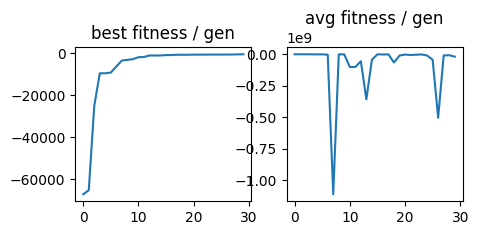

Evolving .dat/f2_-3.14_3.14.dat...


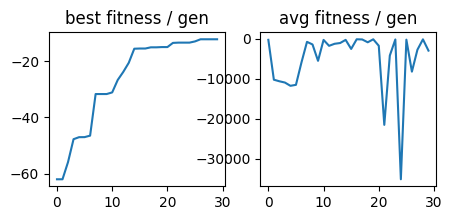

Evolving .dat/f3_0_4.dat...


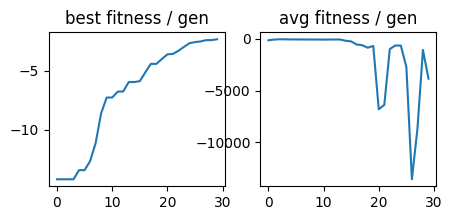

In [6]:
# 5. plots of best_fitness/gen and avg_fitness/gen

from tiny_gp import TinyGP


FILENAMES = [
    ".dat/f1_-10_10.dat",
    ".dat/f2_-3.14_3.14.dat",
    ".dat/f3_0_4.dat",
    # ".dat/f6_-10_10.dat"?
]

# 2. symbolic regression for different functions
for filename in FILENAMES:
    print(f"Evolving {filename}...")
    tgp = TinyGP(filename, lib_name="tiny_gp_no_sin_cos")
    best_fitness = []
    avg_fitness = []
    for _ in range(30):
        tgp.evolve()
        best_fitness.append(tgp.fitness(tgp.best()))
        avg_fitness.append(np.mean([tgp.fitness(i) for i in range(tgp.pop_size)]))

    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    axs[0].plot(best_fitness)
    axs[0].set_title("best fitness / gen")
    axs[1].plot(avg_fitness)
    axs[1].set_title("avg fitness / gen")
    plt.show()
